# EbayesThresh Python화 활용법

SEOYEON CHOI  
2024-05-29

# Install

In [7]:
!pip install git+https://github.com/seoyeonc/ebayesthresh.git

  Cloning https://github.com/seoyeonc/ebayesthresh.git to /tmp/pip-req-build-gh560sa9
  Running command git clone --filter=blob:none --quiet https://github.com/seoyeonc/ebayesthresh.git /tmp/pip-req-build-gh560sa9
  Resolved https://github.com/seoyeonc/ebayesthresh.git to commit ed192d245edf36cd7b6df5ae8ae4b217ae63ac5a
  Preparing metadata (setup.py) ... done
  Created wheel for ebayesthresh: filename=ebayesthresh-0.0.1-py3-none-any.whl size=9740 sha256=da51a5730cd887fcf5e57fc12269c64cdb8626b7257caffa19d05f7bc5c344f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-6lix5_1s/wheels/64/9a/27/4ae710bcecb5e9068c9cf7034acefa27666251c621442dc422
Successfully built ebayesthresh

# Import

In [1]:
import ebayesthresh

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 예제를 위해 필요한 함수 정의

In [3]:
def make_Psi(T):
    W = np.zeros((T,T))
    for i in range(T):
        for j in range(T):
            if i==j :
                W[i,j] = 0
            elif np.abs(i-j) <= 1 : 
                W[i,j] = 1
    d = np.array(W.sum(axis=1))
    D = np.diag(d)
    L = np.array(np.diag(1/np.sqrt(d)) @ (D-W) @ np.diag(1/np.sqrt(d)))
    lamb, Psi = np.linalg.eigh(L)
    return Psi

# Example

In [24]:
T = 100
t = np.arange(T)/T * 10
y_true = 3*np.sin(0.5*t) + 1.2*np.sin(1.0*t) + 0.5*np.sin(1.2*t) 
y = y_true + np.random.normal(size=T)

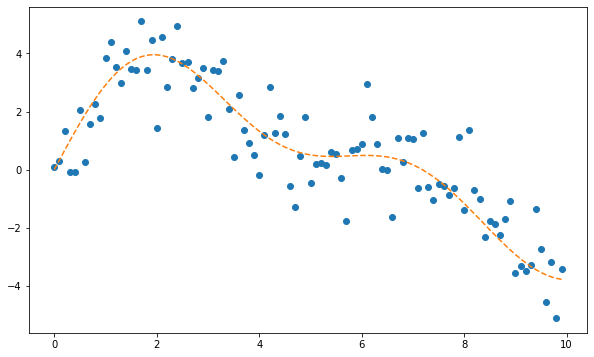

In [25]:
plt.figure(figsize=(10,6))
plt.plot(t,y,'o')
plt.plot(t,y_true,'--')

In [26]:
f = np.array(y)
if len(f.shape)==1: f = f.reshape(-1,1)
T,N = f.shape
Psi = make_Psi(T)
fbar = Psi.T @ f # apply dft 

In [27]:
fbar_threshed = ebayesthresh.ebayesthresh(fbar[:,0])

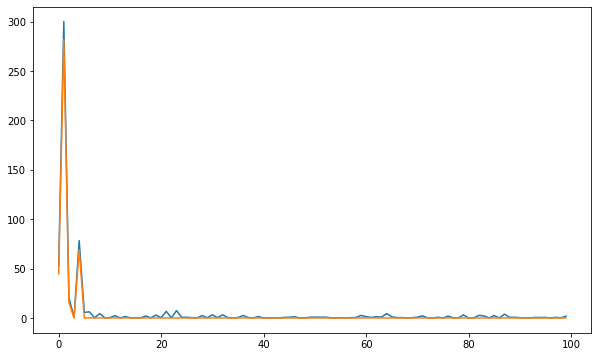

In [28]:
plt.figure(figsize=(10,6))
plt.plot((fbar**2)) # periodogram 
plt.plot((fbar_threshed**2)) 

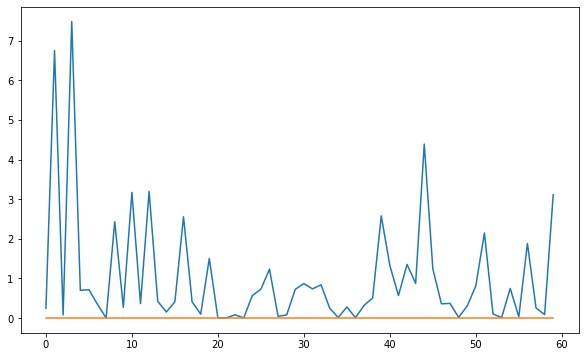

In [29]:
plt.figure(figsize=(10,6))
plt.plot((fbar**2)[20:80]) # periodogram 
plt.plot((fbar_threshed**2)[20:80]) 

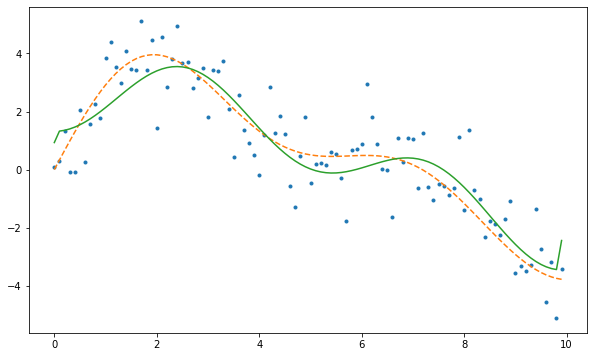

In [30]:
yhat = Psi @ fbar_threshed # inverse dft
plt.figure(figsize=(10,6))
plt.plot(t,y,'.')
plt.plot(t,y_true,'--')
plt.plot(t,yhat)

# 사용자 함수 정의

In [259]:
class ebayesthresh_nn(torch.nn.Module):
    
    def __init__(self):
        super().__init__()

    def forward(self,input, prior="laplace", a = 0.5, bayesfac = False, sdev = None, verbose = True, threshrule = "median", universalthresh = True, stabadjustment = None):
        
        self.prior = prior
        self.a = a
        self.bayesfac = bayesfac
        self.sdev = sdev
        self.verbose = verbose
        self.threshrule = threshrule
        self.universalthresh = universalthresh
        self.stabadjustment = stabadjustment
        
        return ebayesthresh.ebayesthresh(input,self.prior, a=self.a, bayesfac=self.bayesfac, sdev=self.sdev, verbose=self.verbose, threshrule=self.threshrule, universalthresh=self.universalthresh, stabadjustment=self.stabadjustment)

> 데이터

In [260]:
np.random.seed(111)
T = 100
t = np.arange(T)/T * 10
ytrue = 3*np.sin(0.5*t) + 1.2*np.sin(1.0*t) + 0.5*np.sin(1.2*t) 
noise  = np.random.normal(size=T)*0.7
y = ytrue + noise

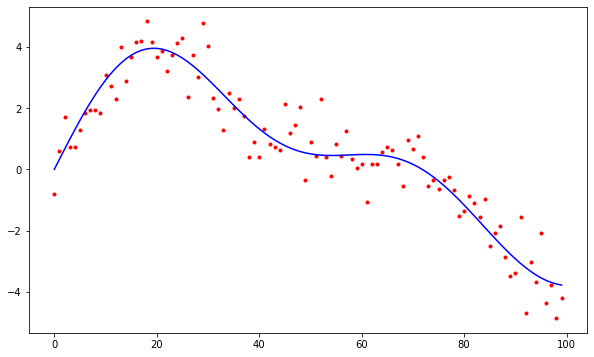

In [261]:
plt.figure(figsize=(10,6))
plt.plot(y,'.',color='r')
plt.plot(ytrue,'-',color='b')

> 레이어 정의

In [263]:
thresh_layer = ebayesthresh_nn()

> Fourier Transform

In [264]:
Psi = make_Psi(T)

In [265]:
ybar = Psi.T @ y

> Learn

In [266]:
power_threshed = thresh_layer(ybar)

> Inverse Fourier Transform

In [267]:
ytrue_hat = Psi@power_threshed['muhat']

In [275]:
power_threshed

> Result

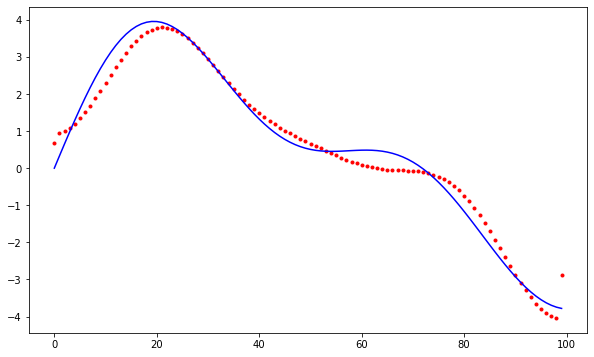

In [268]:
plt.figure(figsize=(10,6))
plt.plot(ytrue_hat,'.',color='r')
plt.plot(ytrue,'-',color='b')

> MSE

In [269]:
loss = criterion(torch.tensor(ytrue_hat, requires_grad=True), torch.tensor(ytrue, requires_grad=True))
loss.item()